In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import unicodedata
import json
import os
import concurrent.futures
import time
from surprise import *
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
import glob
import matplotlib.pyplot as plt

# load all data

In [3]:
directory = "../letterboxd_proj_data/"
reviews = []

for file_path in glob.iglob(os.path.join(directory, "usernames*")):
    with open(file_path) as f:
        for line in f:
            reviews.append(json.loads(line))
    
ratings_df = pd.DataFrame(reviews)

In [4]:
ratings_df_clean = ratings_df.dropna()

In [5]:
print(ratings_df.columns)
print(ratings_df.head())
print(ratings_df.size)

Index(['user', 'title', 'review_date', 'rating', 'liked', 'review_text'], dtype='object')
         user               title  review_date  rating  liked  \
0  deathproof          The Monkey   1739952000     3.5      0   
1  deathproof  Paddington in Peru   1739779200     3.5      0   
2  deathproof        Emilia Pérez   1738656000     NaN      0   
3  deathproof              Wicked   1738396800     3.5      0   
4  deathproof       The Brutalist   1735977600     4.5      1   

                                         review_text  
0        who else up late playing with their monkey?  
1  not to sound predictable but this was so silly...  
2  uh so anyways... a few films i recommend inste...  
3  to the absolute diva behind me in the theater ...  
4  gargantuan. there is a single shot near the en...  
41274786


In [6]:
# missing value based on like vs not like
print('1', ratings_df[ratings_df['liked']==1]['rating'].isna().sum(), '0', ratings_df[ratings_df['liked']==0]['rating'].isna().sum())

1 206055 0 227560


In [7]:
print('users', np.unique(ratings_df_clean['user']).shape, 'items', np.unique(ratings_df_clean['title']).shape)

users (5805,) items (202515,)


In [8]:
ratings_df_clean[['rating', 'liked']].mean()

rating    3.424474
liked     0.418063
dtype: float64

# grouped by user

In [9]:
def review_length(series):
    return series.str.split().str.len()  # Splits by space & counts words

In [10]:
grouped_df = ratings_df_clean.groupby(by='user').agg({'rating': ['mean'], 'liked': ['mean', 'count'], 'review_text': [lambda x: review_length(x).mean(), lambda x: review_length(x).std()]})
grouped_df.head()

rating     liked       review_text           
                    mean      mean count  <lambda_0> <lambda_1>
user                                                           
000_leo         2.907817  0.020649   678   15.299410   7.074432
007filmreviwer  3.282209  0.728667  3586   58.381484  28.446540
007hertzrumble  3.414615  0.671154  2600   56.741538  27.463112
0o0o0o0o        3.205882  0.117647    51   37.666667  32.299639
11122001        3.586792  0.781132   265   19.720755  18.480470

In [11]:
grouped_df.columns

MultiIndex([(     'rating',       'mean'),
            (      'liked',       'mean'),
            (      'liked',      'count'),
            ('review_text', '<lambda_0>'),
            ('review_text', '<lambda_1>')],
           )

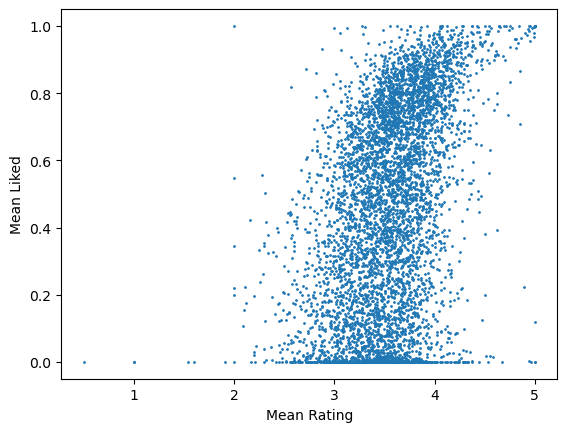

In [12]:
plt.scatter(grouped_df['rating']['mean'], grouped_df['liked']['mean'], s=1)
# Add axis labels
plt.xlabel("Mean Rating")
plt.ylabel("Mean Liked")

# Show the plot
plt.show()

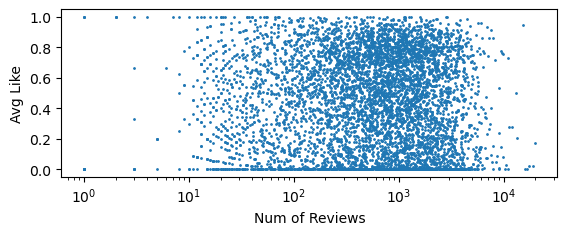

In [13]:
# basically no correlation between number of reviews and how often they like
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.scatter(grouped_df['liked']['count'], grouped_df['liked']['mean'], s=1)
# Add axis labels
ax.set_xlabel("Num of Reviews")
ax.set_ylabel("Avg Like")
ax.set_xscale('log')

# Show the plot
plt.show()

# impute missing values based on like vs dislike


In [22]:
user_liked_mean = ratings_df.groupby(['user', 'liked'])['rating'].mean().reset_index()
user_liked_mean = user_liked_mean.rename(columns={'rating': 'imputed_rating'})

# Step 2: Merge mean rating back into the original DataFrame
df_imputed = ratings_df.merge(user_liked_mean, on=['user', 'liked'], how='left')

# Step 3: Fill missing ratings with the computed mean for liked/disliked items
df_imputed['rating'] = df_imputed['rating'].fillna(df_imputed['imputed_rating'])

# Drop the temporary 'imputed_rating' column
df_imputed.drop(columns=['imputed_rating'], inplace=True)

# 62k entries where there are no ratings for a user
df_imputed['rating'].isna().sum()

62684

In [23]:
df_imputed = df_imputed.dropna()

In [ ]:
# df_imputed.to_csv("../letterboxd_proj_data/df_imputed")

In [7]:
ratings_df.to_csv('../letterboxd_proj_data/reviews.csv', index=False)

In [ ]:
# grouped_df.to_csv('../letterboxd_proj_data/df_grouped.csv')

In [5]:
ratings_df.columns

Index(['user', 'title', 'review_date', 'rating', 'liked', 'review_text'], dtype='object')